## EfficientNetB0

- https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43

### Configration

In [1]:
# モジュールの動的import(import先のファイルが更新されたときに追従する)
%load_ext autoreload
%autoreload 2

In [2]:
import os, gc

import numpy as np
import polars as pl

import tensorflow as tf
import matplotlib.pyplot as plt

print("TensorFlow version =", tf.__version__)

2024-02-12 02:06:33.397691: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-12 02:06:33.501478: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version = 2.12.0


In [3]:
config = {
  "MIX": True,
  "SPEC_FILE_PATH": "/kaggle/input/train_spectrograms/",
  "EEG_FILE_PATH": "/kaggle/input/train_eegs/",
}

In [4]:
# 自動混合精度の設定
# https://cocoinit23.com/tensowflow-automatic-mixed-precision/
if config["MIX"]:
  tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
  print("Mixed precision enabled")
else:
  print("Using full precision")

Mixed precision enabled


### Load train csv

In [5]:
train_df = pl.read_csv("/kaggle/input/train.csv")
label_columns = train_df.columns[-6:]

print("Train shape: ", train_df.shape)
print("label columns: ", list(label_columns))
train_df.head()

Train shape:  (106800, 15)
label columns:  ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
i64,i64,f64,i64,i64,f64,i64,i64,str,i64,i64,i64,i64,i64,i64
1628180742,0,0.0,353733,0,0.0,127492639,42516,"""Seizure""",3,0,0,0,0,0
1628180742,1,6.0,353733,1,6.0,3887563113,42516,"""Seizure""",3,0,0,0,0,0
1628180742,2,8.0,353733,2,8.0,1142670488,42516,"""Seizure""",3,0,0,0,0,0
1628180742,3,18.0,353733,3,18.0,2718991173,42516,"""Seizure""",3,0,0,0,0,0
1628180742,4,24.0,353733,4,24.0,3080632009,42516,"""Seizure""",3,0,0,0,0,0


#### Create Non-Overlapping eeg_id train data

In [6]:
agg_columns = [
  pl.col("spectrogram_id").first().alias("spec_id"),
  pl.col("spectrogram_label_offset_seconds").min().alias("min"),
  pl.col("spectrogram_label_offset_seconds").max().alias("max"),
  pl.col("patient_id").first().alias("patient_id"),
]
agg_columns += [pl.col(v).sum().alias(v) for v in label_columns] # 後で割合を出す

processed_train_df = train_df.group_by("eeg_id").agg(agg_columns)

# label_columnsそれぞれの割合を出す
label_data = processed_train_df.select(label_columns).to_numpy()
label_data = label_data / label_data.sum(axis=1, keepdims=True)

processed_train_df[label_columns] = label_data

# label
tmp_df = train_df.group_by("eeg_id").agg(pl.col("expert_consensus").first().alias("label"))
processed_train_df = processed_train_df.join(tmp_df, on="eeg_id", how="left")

print("Train non-overlap eeg_id shape: ", processed_train_df.shape)
processed_train_df.head()

Train non-overlap eeg_id shape:  (17089, 12)


eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,label
i64,i64,f64,f64,i64,f64,f64,f64,f64,f64,f64,str
588219488,497757168,0.0,46.0,37962,0.071429,0.928571,0.0,0.0,0.0,0.0,"""LPD"""
1473973712,1573731619,0.0,70.0,9371,0.0,0.529412,0.0,0.117647,0.294118,0.058824,"""LPD"""
2170436464,864430283,0.0,18.0,25461,1.0,0.0,0.0,0.0,0.0,0.0,"""Seizure"""
2109965536,1774087474,0.0,10.0,19311,0.0,0.866667,0.066667,0.0,0.0,0.066667,"""LPD"""
1650259088,40912716,430.0,434.0,24432,0.0,0.333333,0.0,0.0,0.666667,0.0,"""GRDA"""


### Load train spectrograms

In [7]:
%%time
files = os.listdir(config["SPEC_FILE_PATH"])
print(f"There are {len(files)} spectrogram parquets")

specs = {}
for i, v in enumerate(files):
  tmp_df = pl.read_parquet(f"{config['SPEC_FILE_PATH']}{v}")
  name = int(v.split('.')[0])

  specs[name] = tmp_df.drop("time").to_numpy()

print(specs[355932412])

There are 11138 spectrogram parquets
[[1.745e+01 2.443e+01 4.322e+01 ... 5.000e-02 6.000e-02 6.000e-02]
 [2.023e+01 2.412e+01 3.494e+01 ... 2.000e-02 2.000e-02 2.000e-02]
 [1.380e+01 1.441e+01 2.312e+01 ... 3.000e-02 4.000e-02 3.000e-02]
 ...
 [1.217e+01 1.056e+01 1.605e+01 ... 3.000e-02 4.000e-02 4.000e-02]
 [2.046e+01 2.354e+01 3.197e+01 ... 3.000e-02 7.000e-02 4.000e-02]
 [3.894e+01 4.162e+01 4.446e+01 ... 3.000e-02 5.000e-02 5.000e-02]]
CPU times: user 4min 8s, sys: 1min 25s, total: 5min 34s
Wall time: 47.5 s


### Load train eeg

In [8]:
%%time
eegs = {}
for i, v in enumerate(processed_train_df.select("eeg_id").to_numpy().flatten()):
  tmp_df = pl.read_parquet(f"{config['EEG_FILE_PATH']}{v}.parquet")

  eegs[v] = tmp_df.to_numpy()

print(eegs[1954249952])

[[-26.21 -45.97 -41.32 ...  83.56  91.09  25.4 ]
 [-14.54 -24.99 -22.79 ... 105.72 111.38  20.99]
 [-16.72 -30.2  -27.19 ...  96.84 104.32   7.76]
 ...
 [ 56.88  23.25 -15.22 ... -47.74 -47.56  33.06]
 [ 62.64  30.21  -8.   ... -35.95 -36.98  18.16]
 [ 45.13   3.59 -29.06 ... -62.91 -61.19  -0.75]]
CPU times: user 6min 9s, sys: 3min 21s, total: 9min 31s
Wall time: 39.5 s


### DataLoader

In [9]:
from src.loader.dataloader import DataLoader

train_loader = DataLoader(
  df=processed_train_df,
  specs=specs,
  eegs=eegs,
  label_columns=label_columns,
  batch_size=32,
  shuffle=False,
)

In [10]:
train_loader.__getitem__(0)

(array([[[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          ...,
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],
 
         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          ...,
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],
 
         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          ...,
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          ...,
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],
 
         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          ...,
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],
 
         [[0., 0., 0., 0.],
          [0., 0., 0., 0.]

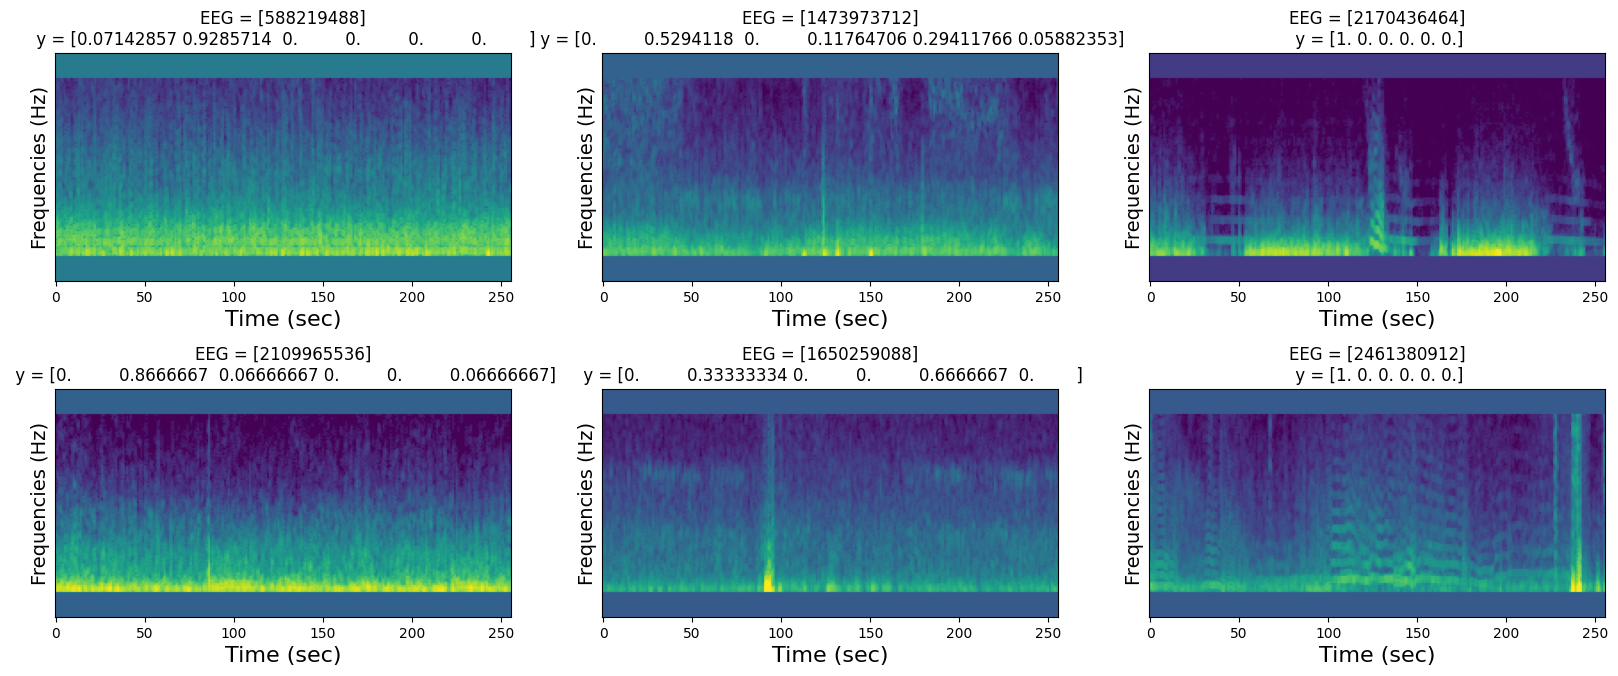

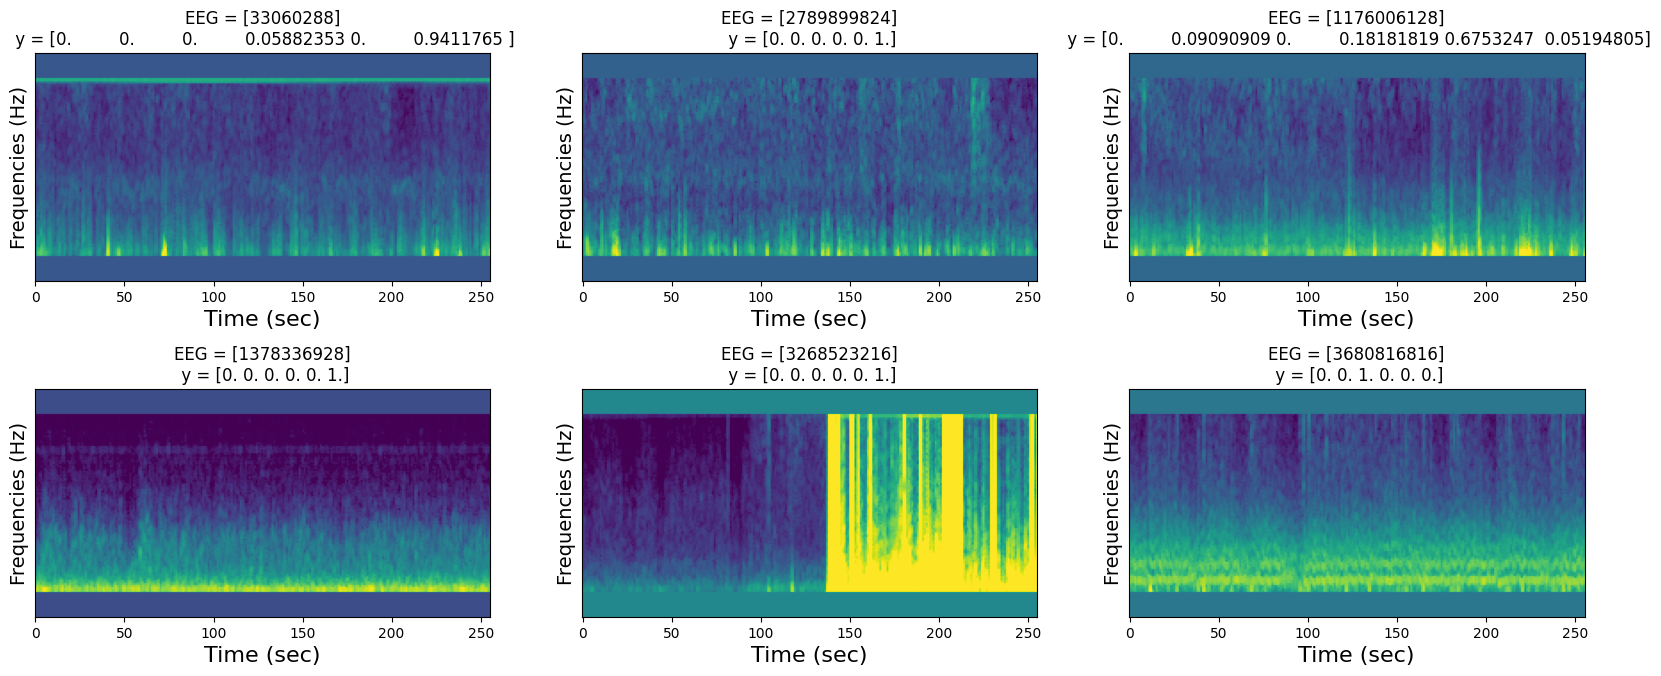

In [11]:
# dataloaderのスペクトログラム画像を表示

ROWS = 2
COLS = 3
BATCHES = 2

for i, (X, y) in enumerate(train_loader):
  plt.figure(figsize=(20,8))
  for j in range(ROWS):
    for k in range(COLS):
      plt.subplot(ROWS, COLS, j*COLS+k+1)

      img = X[j*COLS+k, :, :, 0][::-1,]

      min_value = img.flatten().min()
      max_value = img.flatten().max()
      img = (img-max_value) / (max_value-min_value)

      plt.imshow(img)

      y_s= y[j*COLS+k]

      y_texts = f"[{y_s[0]:0.2f}"
      for v in y_s[1:]:
        y_texts += f", {v:0.2f}"

      eeg = processed_train_df.select("eeg_id")[i*32+j*COLS+k].to_numpy()[0]

      plt.title(f"EEG = {eeg}\n y = {y_s}", size=12)
      plt.yticks([])
      plt.ylabel("Frequencies (Hz)", size=14)
      plt.xlabel("Time (sec)", size=16)

  plt.show()

  if i == (BATCHES -1):
    break




### Train scheduler

- StepTrainScheduleで最初の4epochを学習
- LR = 1e-3 (1, 2epoch) -> 1e-4 (3epoch) -> 1e-5 (4epoch)

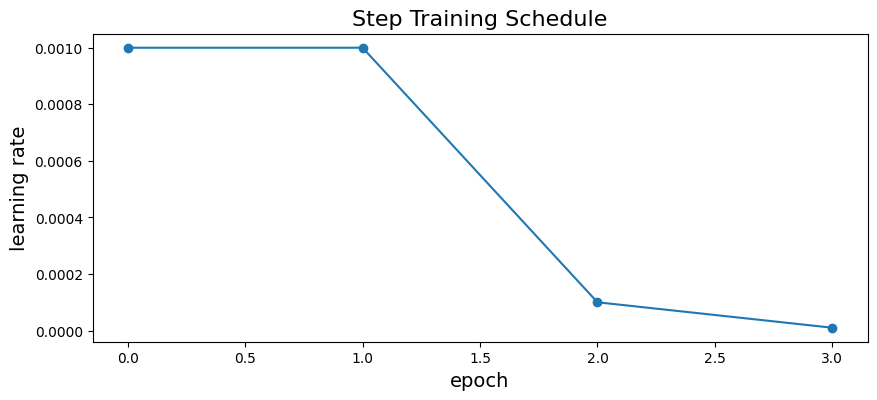

In [12]:
import math

LR_START = 1e-4
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 1
LR_STEP_DECAY = 0.1
EVERY = 1
EPOCHS = 4

def lrfn(epoch):
  if epoch < LR_RAMPUP_EPOCHS:
    lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
  elif epoch < (LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS):
    lr = LR_MAX
  else:
    lr = LR_MAX * LR_STEP_DECAY ** ((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) // EVERY)

  return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

plt.figure(figsize=(10, 4))
plt.plot(rng, y, 'o-')
plt.xlabel("epoch", size=14)
plt.ylabel("learning rate", size=14)
plt.title("Step Training Schedule", size=16)
plt.show()

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)


In [ ]:
! pip install --no-index --find-links=/kaggle/input/tf-efficientnet-whl-files /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl

In [ ]:
from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc

all_oof = []
all_true = []

gkf = GroupKFold(n_splits=5)
for i, (train_ix, valid_ix) in enumerate(
  gkf.split(processed_train_df, processed_train_df.select["target"], processed_train_df.select["patient_id"])):
  print(f"Fold {i+1}")

  train_loader = DataLoader(
    df=processed_train_df.iloc[train_ix],
    shuffle=True,
    batch_size=32,
    augment=False,
  )
  valid_loader = DataLoader(
    df=processed_valid_df.iloc[valid_ix],
    shuffle=False,
    batch_size=64,
    mode="valid",
  )

  print(f"train size {len(train_ix)}, valid size {len(valid_ix)}")

  K.clear_session()

  with strategy.scope():
    model = EfficientNetB0()

  if LOAD_MODELS_FROM is None:
    model.fit(
      train_loader,
      verbose=1,
      validation_data=valid_loader,
      epochs=EPOCHS,
      callbacks=[LR],
    )

    model.save_weights(f"EfficientNet_v0_f{i}.h5")
  else:
    model.load_weights(f"Efficient")




